<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#rawd'>Raw data</a>
    * <a href='#raw:preprocessing'>Preprocessing</a>
        * <a href='#raw:pre:function'>Preprocessing function definition</a>
        * <a href='#raw:pre:data'>Data loading</a>
        * <a href='#raw:pre:imputation'>Imputation</a>
        * <a href='#raw:pre:outlier'>Outlier removal</a>
* <a href='#goodd'>Processed data</a>

    * <a href='#model_1'>Model definition</a>


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

In [2]:
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
import warnings
from ipywidgets import IntProgress
from IPython import display
#############
from sklearn.svm import OneClassSVM

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

<a href='#index'>...</a>
<a id='rawd'></a>
# Raw data

<a id='raw:preprocessing'></a>
## Preprocessing

<a id='raw:pre:function'></a>
### Preprocessing function definition

In [3]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None)

In [4]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [5]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

<a id='raw:pre:data'></a>
### Data loading 

In [5]:
root_folder = '../CDSL_HM_20200720_RAW'

# CDSL_01
df_patient = pd.read_csv(root_folder+'/CDSL_01.csv', sep=';')
# CDSL_02
df_med = pd.read_csv(root_folder+'/CDSL_02.csv', sep=';')
# CDSL_03
df_cons = pd.read_csv(root_folder+'/CDSL_03.csv', sep=';')
# CDSL_05 (emergency)
df_ICD10_emer = pd.read_csv(root_folder+'/CDSL_05.csv', sep=';')
# CDSL_06  (admission)
df_ICD10_adm = pd.read_csv(root_folder+'/CDSL_06.csv', sep=';')

In [6]:
# CDSL_04
df_lab = pd.read_csv(root_folder+'/CDSL_04.csv', sep=';', error_bad_lines=False, encoding='iso-8859-1')

b'Skipping line 28039: expected 8 fields, saw 12\nSkipping line 32182: expected 8 fields, saw 12\nSkipping line 44299: expected 8 fields, saw 12\n'
b'Skipping line 90790: expected 8 fields, saw 12\nSkipping line 105234: expected 8 fields, saw 12\nSkipping line 130735: expected 8 fields, saw 10\n'
b'Skipping line 136659: expected 8 fields, saw 10\nSkipping line 140398: expected 8 fields, saw 10\nSkipping line 141687: expected 8 fields, saw 12\nSkipping line 142745: expected 8 fields, saw 12\nSkipping line 170183: expected 8 fields, saw 12\n'
b'Skipping line 223336: expected 8 fields, saw 21\nSkipping line 237392: expected 8 fields, saw 12\n'
b'Skipping line 373889: expected 8 fields, saw 12\nSkipping line 382978: expected 8 fields, saw 10\n'
b'Skipping line 412136: expected 8 fields, saw 12\nSkipping line 419764: expected 8 fields, saw 12\nSkipping line 421226: expected 8 fields, saw 12\nSkipping line 426429: expected 8 fields, saw 11\nSkipping line 444865: expected 8 fields, saw 12\n'


##### df_patient

Renaming and reindexing *df_patient*.


In [7]:
df_patient = df_patient.rename(columns=
                        {"PATIENT ID":"PATIENT_ID", "EDAD/AGE":"AGE", "SEXO/SEX":"SEX", "DIAG ING/INPAT":"DIAG_INPAT", 
                        "F_INGRESO/ADMISSION_D_ING/INPAT":"ADMISSION_DATE_INPAT","HORA/TIME_ADMISION/ADMISSION_URG/EMERG":
                         "TIME_ADMISSION_EMERG","F_ENTRADA_UC/ICU_DATE_IN":"ICU_DATE_IN", 
                        "F_SALIDA_UCI/ICU_DATE_OUT":"ICU_DATE_OUT","UCI_DIAS/ICU_DAYS": "ICU_DAYS", 
                        "RESPIRADOR/MECH.VENT.":"MECH.VENT.", "F_ALTA/DISCHARGE_DATE_ING":"DISCHARGE_DATE_ING", 
                        "MOTIVO_ALTA/DESTINY_DISCHARGE_ING":"DESTINY_DISCHARGE_ING","F_INGRESO/ADMISSION_DATE_URG/EMERG":
                        "ADMISSION_DATE_EMERG", "HORA/TIME_ADMISION/ADMISSION_EMERG/EMERG":"TIME_ADMISION_EMERG", 
                        "ESPECIALIDAD/DEPARTMENT_URG/EMERG":"DEPARTMENT_EMERG","DIAG_URG/EMERG":"DIAG_EMERG", 
                        "DESTINO/DESTINY_URG/EMERG":"DESTINY_EMERG", "HORA/TIME_CONSTANT_PRIMERA/FIRST_URG/EMERG" : 
                        "TIME_CONSTANT_FIRST_EMERG", "TEMP_PRIMERA/FIRST_URG/EMERG":"TEMP_FIRST_EMERG", "FC/HR_PRIMERA/FIRST_URG/EMERG": 
                        "HR_FIRST_EMERG", "GLU_PRIMERA/FIRST_URG/EMERG":"GLU_FIRST_EMERG", "SAT_02_PRIMERA/FIRST_URG/EMERG":
                        "SAT_02_FIRST_EMERG", "TA_MAX_PRIMERA/FIRST/EMERG_URG":"TA_MAX_FIRST_EMERG", "TA_MIN_PRIMERA/FIRST_URG/EMERG":
                        "TA_MIN_FIRST_EMERG", "HORA/TIME_CONSTANT_ULTIMA/LAST_URG/EMERG":"TIME_CONSTANT_LAST_EMERG", 
                        "FC/HR_ULTIMA/LAST_URG/EMERG":"HR_LAST_EMERG", "TEMP_ULTIMA/LAST_URG/EMERG":"TEMP_LAST_EMERG", 
                        "GLU_ULTIMA/LAST_URG/EMERG":"GLU_LAST_EMERG", "SAT_02_ULTIMA/LAST_URG/EMERG":"SAT_02_LAST_EMERG", 
                        "TA_MAX_ULTIMA/LAST_URGEMERG":"TA_MAX_LAST_EMERG", "TA_MIN_ULTIMA/LAST_URG/EMERG":"TA_MIN_LAST_EMERG"})

custom_columns = ['PATIENT_ID', 'AGE', 'SEX', 
                  'DIAG_INPAT', 'ADMISSION_DATE_INPAT',
                  'ADMISSION_DATE_EMERG','DISCHARGE_DATE_ING','TIME_ADMISSION_EMERG', 
                  'DEPARTMENT_EMERG', 'DIAG_EMERG','DESTINY_EMERG',
                  'ICU_DATE_IN', 'ICU_DATE_OUT','ICU_DAYS', 
                  'MECH.VENT.', 'TIME_CONSTANT_FIRST_EMERG', 'TIME_CONSTANT_LAST_EMERG', 
                  'HR_FIRST_EMERG','HR_LAST_EMERG',
                  'SAT_02_FIRST_EMERG', 'SAT_02_LAST_EMERG',
                  'TA_MAX_FIRST_EMERG','TA_MAX_LAST_EMERG',
                  'TA_MIN_FIRST_EMERG','TA_MIN_LAST_EMERG', 
                  'TEMP_FIRST_EMERG','TEMP_LAST_EMERG',
                  'GLU_FIRST_EMERG','GLU_LAST_EMERG',
                  'DESTINY_DISCHARGE_ING']

df_patient = df_patient.reindex(columns=custom_columns)

Statistical data.

In [8]:
print("MALE/FEMALE: {:.2f}%".format(100*column_percentage(df_patient,'SEX','MALE')))
print("CONFIRMED COVID/SUSPECTED COVID: {:.2f}%".format(100*column_percentage(df_patient,'DIAG_INPAT','COVID CONFIRMADO')))
print("DECEASED/OTHERWISE: {:.2f}%".format(100*column_percentage(df_patient,'DESTINY_DISCHARGE_ING','Fallecimiento')))
print("Admitted patients (not previous ER): {} \nAdmitted patients (previous ER): {}".format(\
      df_patient.shape[0] - len(df_patient[~df_patient['ADMISSION_DATE_EMERG'].isnull()]), \
      len(df_patient[~df_patient['ADMISSION_DATE_EMERG'].isnull()])))

MALE/FEMALE: 58.78%
CONFIRMED COVID/SUSPECTED COVID: 90.97%
DECEASED/OTHERWISE: 14.96%
Admitted patients (not previous ER): 90 
Admitted patients (previous ER): 2457


Creation of *ICU* and *ER* features. Value 1 for those patients that have previously been in ER. Value 1 for those patients that have been in the need of *ICU*. Otherwise, 0.

In [9]:
# Cast PATIENT_ID to int
df_patient['PATIENT_ID']=df_patient['PATIENT_ID'].astype("int")

# Create ICU feature
df_patient['ICU']=0
df_patient.loc[~df_patient['ICU_DAYS'].isnull(),['ICU']]=1
df_patient['ICU']=df_patient['ICU'].astype("category")

# Create ER feature
df_patient['ER']=0
df_patient.loc[~df_patient['ADMISSION_DATE_EMERG'].isnull(),['ER']]=1
df_patient['ER']=df_patient['ER'].astype("category")


Removal of columns:
* "Date" or "Time" columns.
* "Last check" columns.
* "DESTINY_EMERG", al patients were admitted.


In [10]:
# REMOVE COLUMNS OF DATES (WHY USE THEM?): 'ICU_DATE_IN','ICU_DATE_OUT','ICU_DAYS','TIME_ADMISSION_EMERG',
                                          # 'DISCHARGE_DATE_ING', 'TIME_CONSTANT_FIRST_EMERG'
# REMOVE ADMISSION DATES TOO...           # 'ADMISSION_DATE_INPAT', 'ADMISSION_DATE_EMERG'  

# REMOVE LAST CHECK COLUMNS (?): 'TIME_CONSTANT_LAST_EMERG', 'HR_LAST_EMERG', 'SAT_02_LAST_EMERG', 
                                # TA_MIN_LAST_EMERG', 'TA_MAX_LAST_EMERG',
                                # 'TEMP_LAST_EMERG', 'GLU_LAST_EMERG'
        
# REMOVE 'DESTINY_EMERG', all samples are "ingresado"

df_patient = df_patient.drop(columns=['ICU_DATE_IN','ICU_DATE_OUT','ICU_DAYS','TIME_ADMISSION_EMERG',
                                      'DISCHARGE_DATE_ING','TIME_CONSTANT_LAST_EMERG', 'HR_LAST_EMERG',
                                      'SAT_02_LAST_EMERG', 'TA_MIN_LAST_EMERG', 'TA_MAX_LAST_EMERG',
                                      'TEMP_LAST_EMERG', 'GLU_LAST_EMERG','DESTINY_EMERG','TIME_CONSTANT_FIRST_EMERG',
                                      'ADMISSION_DATE_INPAT','ADMISSION_DATE_EMERG'])


##### df_med

##### df_cons

In [36]:
#df_cons.info()

# Rename columns
df_cons.rename(columns={'IDINGRESO':'ID_PATIENT'})
# Format 'TEMP_ING'
df_cons['TEMP_ING']=pd.to_numeric(df_cons['TEMP_ING'], errors='coerce')

##### df_lab

<a href=https://www.sciencedirect.com/science/article/abs/pii/S0009898120304125>Source</a>

Laboratory features cut-off values (severe):

* Lymphocyte  (LIN  -- linfocitos)  <0.8*10e3/µL
* Lymphocyte% (LIN% -- linfocitos)  <15% of total white blood cells

* Neutrophils  (NEU  -- Neutrofilos) >3.5e3/µL
* Neutrophils% (NEU% -- Neutrofilos) 

* Plaletes (PLAQ -- Recuento de plaquetas) <150e3/µL

* D-dimer (DD -- DIMERO D) >400ng/mL

* LDH (LDH -- LDH) >280U/L



In [37]:
total = df_patient['PATIENT_ID']
unique_lab = df_lab['IDINGRESO'].unique()

total_lab_common = len(set(np.array(total)).intersection(set(unique_lab)))
print("Number of patients with laboratory records: {} ({:.2f}%)".format(total_lab_common, total_lab_common/len(total)*100))

Number of patients with laboratory records: 2433 (95.52%)


**df_ICD10_emer, df_ICD10_adm**

In [38]:
# Remove rows without labeled patient
df_ICD10_adm = df_ICD10_adm.drop(df_ICD10_adm.index[df_ICD10_adm['IDINGRESO'].isnull()].to_list())
# df_ICD10_adm has no non-labeled patient

# Convert categorical the whole df
df_ICD10_adm['IDINGRESO']=df_ICD10_adm['IDINGRESO'].astype("int")
df_ICD10_emer['IDINGRESO']=df_ICD10_emer['IDINGRESO'].astype("int")

In [39]:
# Number of patients with CIE10 codification in df_patients
# CIE10_id_patient = pd.concat(df_ICD10_emer['IDINGRESO'].unique(), df_ICD10_adm['IDINGRESO']).unique()
total = df_patient['PATIENT_ID']
unique_ICD10_adm = df_ICD10_adm['IDINGRESO']
unique_ICD10_emer = df_ICD10_emer['IDINGRESO']
unique_CIE10 = pd.concat([unique_ICD10_adm, unique_ICD10_emer], axis=0).unique()
total_reg_common = len(set(np.array(unique_CIE10)).intersection(set(total)))

print("Number of patients with records of the emergency (ICD10 standard): {} ({:.2f}%)".format(len(unique_ICD10_emer),len(unique_ICD10_emer)/len(total)*100))
print("Number of inpatients with record (ICD10 standard): {} ({:.2f}%)".format(len(unique_ICD10_adm),len(unique_ICD10_adm)/len(total)*100))
print("Number of patients (admission and emergency) with record (ICD10 standard): {} ({:.2f}%)".format(total_reg_common, total_reg_common/len(total)*100))

Number of patients with records of the emergency (ICD10 standard): 2454 (96.35%)
Number of inpatients with record (ICD10 standard): 2531 (99.37%)
Number of patients (admission and emergency) with record (ICD10 standard): 2544 (99.88%)


<a id='raw:pre:imputation'></a>
### Imputation

##### df_patient

Imputation of categorical fields.

In [11]:
# DIAG_EMERG
df_patient['DIAG_EMERG']=df_patient['DIAG_EMERG'].fillna(value='Unknown')
df_patient['DIAG_EMERG']=df_patient['DIAG_EMERG'].astype("category")
# MECHANICAL VENTILATION
df_patient['MECH.VENT.']=df_patient['MECH.VENT.'].fillna(value='NO')
df_patient['MECH.VENT.']=df_patient['MECH.VENT.'].astype("category")
# MECHANICAL VENTILATION
df_patient['DEPARTMENT_EMERG']=df_patient['DEPARTMENT_EMERG'].fillna(value='Unknown')
df_patient['DEPARTMENT_EMERG']=df_patient['DEPARTMENT_EMERG'].astype("category")
# DESTINY_DISCHARGE_ING
df_patient['DESTINY_DISCHARGE_ING']=df_patient['DESTINY_DISCHARGE_ING'].fillna(value='Unknown')
df_patient['DESTINY_DISCHARGE_ING']=df_patient['DESTINY_DISCHARGE_ING'].astype("category")
# SEX
df_patient['SEX']=df_patient['SEX'].astype("category")
# DIAG_INPAT
df_patient['DIAG_INPAT']=df_patient['DIAG_INPAT'].astype("category")


Imputation of numerical fields.

Number of 0's:
* HR_FIRST_EMERG 	607 (23.83%)
* SAT_02_FIRST_EMERG 	574 (22.54%)
* TA_MAX_FIRST_EMERG 	927 (36.40%)
* TA_MIN_FIRST_EMERG 	928 (36.44%)
* TEMP_FIRST_EMERG 	629 (24.70%)
* GLU_FIRST_EMERG 	2519 (98.90%)


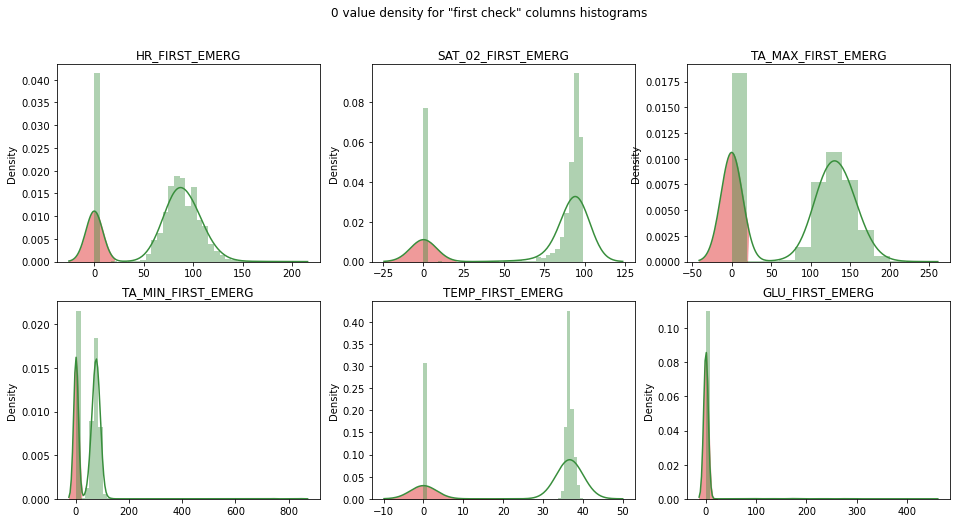

In [12]:
columns_first_check = ['HR_FIRST_EMERG', 'SAT_02_FIRST_EMERG', 'TA_MAX_FIRST_EMERG', 'TA_MIN_FIRST_EMERG',
                       'TEMP_FIRST_EMERG', 'GLU_FIRST_EMERG']
plot_zero_relevance(df_patient, columns_first_check, 2, 3, '0 value density for "first check" columns histograms', verbose=1)

Removing 'GLU_FIRST_EMERG' which has a 98.90% of zeros (missing data), and it makes inviables any imputation.

Imputation of ['HR_FIRST_EMERG', 'SAT_02_FIRST_EMERG', 'TA_MAX_FIRST_EMERG', 'TA_MIN_FIRST_EMERG', 'TEMP_FIRST_EMERG'] based on the mean of each column.

Number of 0's:
* HR_FIRST_EMERG 	0 (0.00%)
* SAT_02_FIRST_EMERG 	0 (0.00%)
* TA_MAX_FIRST_EMERG 	0 (0.00%)
* TA_MIN_FIRST_EMERG 	0 (0.00%)
* TEMP_FIRST_EMERG 	0 (0.00%)


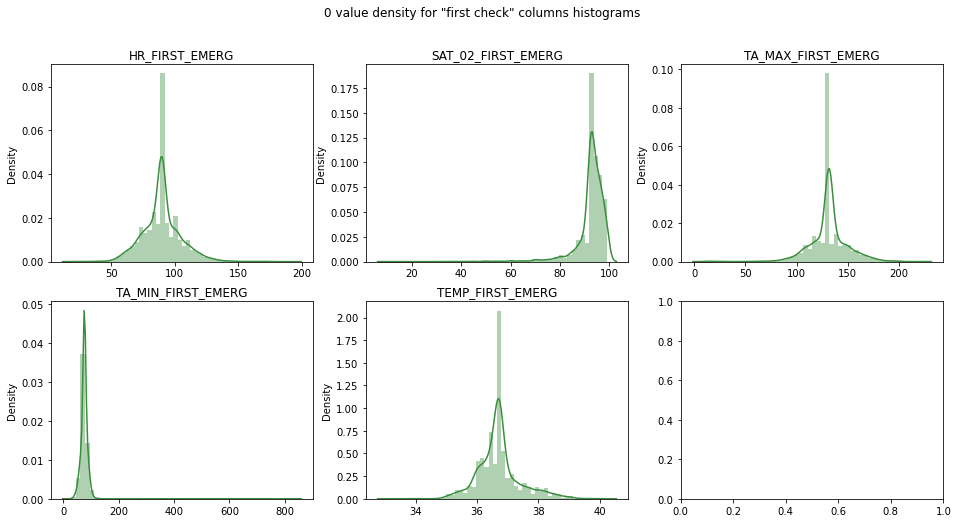

In [13]:
###### TEMPORAL
df_patient= df_patient.drop(columns=['GLU_FIRST_EMERG'])

imp = SimpleImputer(missing_values=0, strategy='mean')
df_patient[columns_first_check[:-1]] = pd.DataFrame(imp.fit_transform(df_patient[columns_first_check[:-1]]))


plot_zero_relevance(df_patient, columns_first_check[:-1], 2, 3, '0 value density for "first check" columns histograms', verbose=1)

In [14]:
df_patient.describe()

,PATIENT_ID,AGE,HR_FIRST_EMERG,SAT_02_FIRST_EMERG,TA_MAX_FIRST_EMERG,TA_MIN_FIRST_EMERG,TEMP_FIRST_EMERG
count,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000,2547.000000
mean,1287.838241,67.912839,89.760309,92.533705,131.456173,75.816553,36.713399
std,742.530258,16.719095,14.894306,6.111976,18.420525,22.767365,0.699968
min,1.000000,0.000000,21.000000,10.000000,10.000000,11.000000,33.200000
25%,648.500000,57.000000,82.000000,92.000000,125.000000,72.000000,36.300000
50%,1290.000000,70.000000,89.760309,93.000000,131.456173,75.816553,36.713399
75%,1931.500000,80.000000,97.000000,96.000000,138.000000,79.000000,36.900000
max,2571.000000,106.000000,190.000000,99.000000,220.000000,845.000000,40.100000


##### df_med

##### df_cons

Number of 0's:
* TA_MAX_ING 	100181 (78.26%)
* TA_MIN_ING 	100189 (78.27%)
* TEMP_ING 	63102 (49.30%)
* FC_HR_ING 	81202 (63.44%)
* SAT_02_ING 	66364 (51.84%)
* GLU_GLY_ING 	128005 (100.00%)


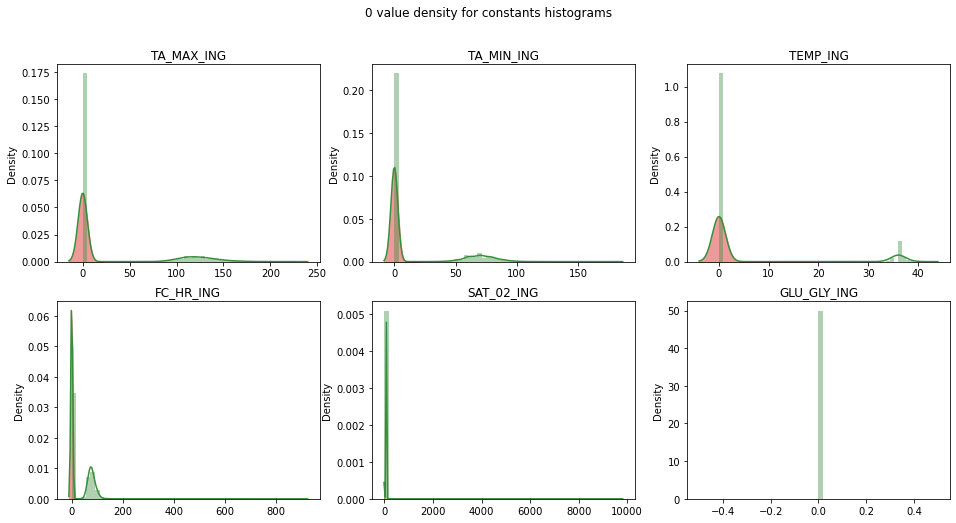

In [29]:
columns_cons = ['TA_MAX_ING', 'TA_MIN_ING', 'TEMP_ING', 'FC_HR_ING', 'SAT_02_ING', 'GLU_GLY_ING']
plot_zero_relevance(df_cons, columns_cons, 2, 3, '0 value density for constants histograms', verbose=1)

In [30]:
df_cons = df_cons.drop(columns=['GLU_GLY_ING'])
df_cons['TEMP_ING']=df_cons['TEMP_ING'].fillna(value=0)
imp = SimpleImputer(missing_values=0, strategy='mean')
df_cons[columns_cons[:-1]] = pd.DataFrame(imp.fit_transform(df_cons[columns_cons[:-1]]))


Number of 0's:
* TA_MAX_ING 	0 (0.00%)
* TA_MIN_ING 	0 (0.00%)
* TEMP_ING 	0 (0.00%)
* FC_HR_ING 	0 (0.00%)
* SAT_02_ING 	0 (0.00%)


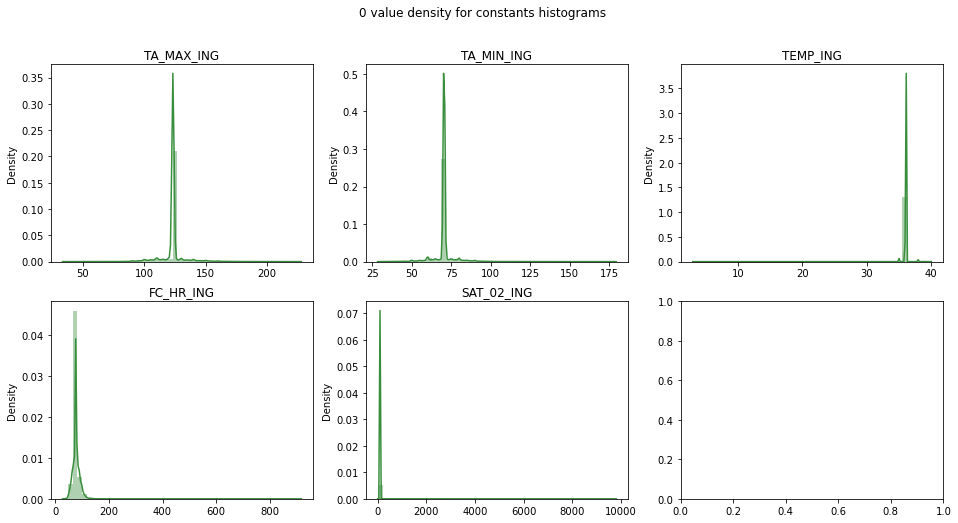

In [31]:
plot_zero_relevance(df_cons, columns_cons[:-1], 2, 3, '0 value density for constants histograms', verbose=1)

In [ ]:
### REPLACE df_patients' constants of patients who had not previously been at the ER (whose constants have value 0).

# A lot of missing values in df_cons

<a id='raw:pre:outlier'></a>
### Outlier removal 

##### df_patient

* <b>HR_FIRST_EMERG</b>
Normal values: 60-90 beats per minute
* <b>SAT_02_FIRST_EMERG</b>
Normal values: 75-100 mmHg
* <b>TA_MAX_FIRST_EMERG</b>
Normal values: 80-120 mmHg
* <b>TA_MIN_FIRST_EMERG</b>
Normal values: 80-120 mmHg
* <b>TEMP_FIRST_EMERG</b>
Normal values: 36-38 ºC
* <b>GLU_FIRST_EMERG</b>
Normal values:70-100 mg/dl (3.9-5.6 mmol/l) ºº

In [86]:
## TEMPORAL

z_scores = stats.zscore(df_patient[columns_first_check[:-1]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_patient = df_patient[filtered_entries]

##### df_med

##### df_cons

<a href='#index'>...</a>
<a id='goodd'></a>
# Processed data

<a id='cured:data'></a>
## Data loading

In [85]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_151
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [86]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
random_state = [42, 89, 101, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, random_state):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
              
    CORE_collection[RS] = (X[0]['CORE'],X[1]['CORE'])
    X_collection[RS] = (X[0].drop(columns=['CORE']), X[1].drop(columns=['CORE']))
    Y_collection[RS] = (Y[0], Y[1])


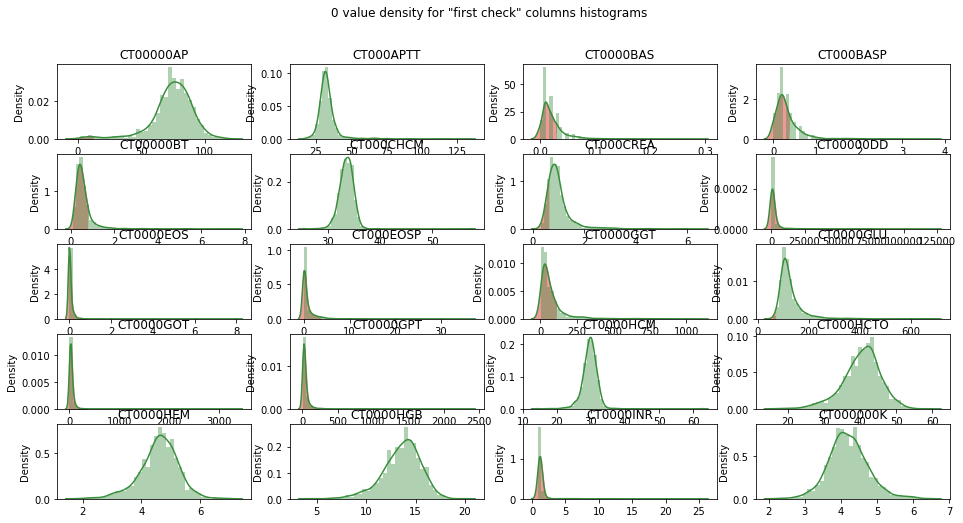

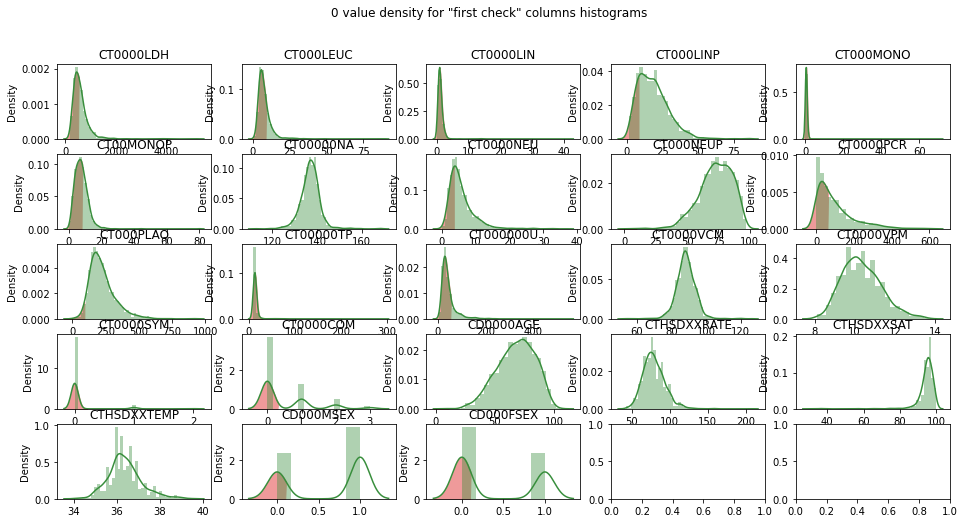

In [101]:
plot_zero_relevance(X_collection[42][0], X_collection[42][0].columns[1:21], 5,4, '0 value density for "first check" columns histograms', verbose=0)
plot_zero_relevance(X_collection[42][0], X_collection[42][0].columns[21:], 5,5, '0 value density for "first check" columns histograms', verbose=0)

<a href='#index'>...</a>
<a id='model_1'></a>
# Model definition

## Supervised models

In [94]:
 # PRUEBA PRINT PROPORCIONES CLASE ANOMALY EN SUBSETS
 '''   
                print('OLD TRAIN/TEST')
                old_train = df_Y.iloc[train_inner]
                old_test = df_Y.iloc[test_inner]
                print(len(old_train.loc[old_train['ED0DISWHY']==0.0]))
                print(len(old_test .loc[old_test['ED0DISWHY']==0.0]))

                print('NEW TRAIN/TEST')

                good_train = df_Y.iloc[n_train]
                print(len(good_train.loc[good_train['ED0DISWHY']==0.0]))
                good_test = df_Y.iloc[n_test]
                print(len(good_test.loc[good_test['ED0DISWHY']==0.0]))
                print('###################')
'''

"   \n               print('OLD TRAIN/TEST')\n               old_train = df_Y.iloc[train_inner]\n               old_test = df_Y.iloc[test_inner]\n               print(len(old_train.loc[old_train['ED0DISWHY']==0.0]))\n               print(len(old_test .loc[old_test['ED0DISWHY']==0.0]))\n\n               print('NEW TRAIN/TEST')\n\n               good_train = df_Y.iloc[n_train]\n               print(len(good_train.loc[good_train['ED0DISWHY']==0.0]))\n               good_test = df_Y.iloc[n_test]\n               print(len(good_test.loc[good_test['ED0DISWHY']==0.0]))\n               print('###################')\n"

In [9]:
df_oc42_Y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ED0DISWHY  1438 non-null   category
dtypes: category(1)
memory usage: 1.7 KB


## Unsupervised models

In [10]:
def oc_split(Y, train, test, normal):
    indexed_train = zip(np.arange(0,train.shape[0],1), train)
    # Index to remove from train set
    del_index = []

    for train_index, df_index in tqdm(indexed_train, total=train.shape[0], desc = 'Transfering anomaly samples from train to test'): 
        sample = Y.iloc[df_index]
        if (sample['ED0DISWHY']!=normal):
            # Append anomaly samples from train to test
            test = np.append(test, df_index)
            # Update train (anomaly) indexes
            del_index.append(train_index)
    # Remove anomaly samples from train
    train = np.delete(train, del_index, 0)
    return train, test


In [177]:
from sklearn.metrics import f1_score, make_scorer
import time
def nested_cv(X, Y, outer_folds, inner_folds, model, parameters, one_class=0, normal_target=1):

    outer_loop=1
    max_score = -1
    score_outer = []
    inner_results = []

    # Define outer-loop
    skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
    for train_outer, test_outer in skfold_outer.split(X, Y):
        display.clear_output(wait=True)
        print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))
        
        # Outer-loop data retrieve
        X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
        Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]
        
        # Define inner loop
        skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)
        
        # Transfering anomaly samples from train to test subsets.
        if (one_class):
            skfold_inner_cv = list()
            for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                # List containing indexes with train subset clear of anomaly samples
                skfold_inner_cv.append((oc_split(Y, train_inner, test_inner, normal_target)))
                # print(len(skfold_inner_cv[-1][0])-Y.iloc[skfold_inner_cv[-1][0]].sum())
        else:
            skfold_inner_cv = skfold_inner
            
        # GRIDSEARCH
        # Obtain best model
        scorer = make_scorer(f1_score, pos_label=1)
        gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
        gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
        inner_results.append(gsearch.cv_results_)
        
        # Best estimator
        estimator = gsearch.best_estimator_
        pred_y = estimator.predict(X_test_outer)
        # print('Predited Y: \n {} \n'.format(pred_y))
        # print('Ground truth Y: \n {} \n'.format(df_Y.iloc[test_outer]))
        score = f1_score(Y.iloc[test_outer], pred_y)
        score_outer.append(score)
        if (score>=max(score_outer)): best_estimator = estimator
            
        outer_loop+=1
        #ime.sleep(10)
    display.clear_output(wait=True)
    print("Summary:")
    for i in range(outer_folds):
        best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
        print("Outer fold nº{}.".format(i+1))
        print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
        print("Score (best of cv): {:.2}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
        print("Score (outer): {:.2}\n".format(score_outer[i]))
    return best_estimator
        

**UNIVERSE 1**

In [162]:
a = {'aa':[1,2,3], 'bb': [4,5,6]}
print("Hola {}".format(a))

Hola {'aa': [1, 2, 3], 'bb': [4, 5, 6]}


In [ ]:

## Previous

# Define models
# 1SVM
# 'C': [0.1, 1, 100, 1000],
#         'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],

params= {
        
        'gamma': [0.0001, 0.001, 0.005, 0.1]
    }

# Model 1

model = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=OneClassSVM(), parameters=params, one_class=1, normal_target = 1)
prediction = model.predict(X_collection[42][1])
score = f1_score(Y_collection[42][1], prediction)
# Model 2

# Model N


Outer loop folds: 5/5


Transfering anomaly samples from train to test:   0%|          | 0/920 [00:00<?, ?it/s]